# **Recommendation System: Fetch similar incidents/bugs related to assigned incident**

Use Case: Developer sometimes are assigned bugs/incidents which are unknown to them. Finding related incidents which have been resolved earlier helps in that situation. This recommendation system based on NLP can be very useful.

Features:
1. Number of related similar events developer desires.
2. Can fetch the similarity based on Incident Summary or Project Description

Link for documentation:
1. https://iwiki.sse.in.tum.de/display/PIT21/Idea+Implementation%3A+Incident+similarity
2. https://iwiki.sse.in.tum.de/display/PIT21/Incidence+Similarity%3A+Models+Study

# Installation of Sentence Transformers

In [1]:
!pip install -U sentence-transformers

     |████████████████████████████████| 92kB 4.3MB/s 
     |████████████████████████████████| 2.5MB 9.0MB/s 
     |████████████████████████████████| 1.2MB 32.2MB/s 
     |████████████████████████████████| 901kB 39.2MB/s 
     |████████████████████████████████| 3.3MB 37.5MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-cp37-none-any.whl size=126711 sha256=9ece6981e449bdcd8fb0a207dc8eafd96c638b37f3665de27be4414eda1223b8
  Stored in directory: /root/.cache/pip/wheels/38/d2/98/d191289a877a34c68aa67e05179521e060f96394a3e9336be6
Successfully built sentence-transformers
ERROR: transformers 4.8.2 has requirement huggingface-hub==0.0.12, but you'll have huggingface-hub 0.0.13 which is incompatible.


# Import Libraries

In [2]:
from sentence_transformers import SentenceTransformer, util
from sentence_transformers import models, losses
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# Mounting google drive where dataset is present
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Read Jira Dataset --Need to provide location of the dataset--
df=pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/jira_data/jira_dataset.csv')
df.head()

,Summary,Issue key,Issue id,Parent id,Issue Type,Status,Project key,Project name,Project type,Project lead,Project description,Project url,Priority,Resolution,Assignee,Reporter,Creator,Created,Updated,Last Viewed,Resolved,Due Date,Votes,Labels,Description,Environment,Watchers,Watchers.1,Log Work,Log Work.1,Original Estimate,Remaining Estimate,Time Spent,Work Ratio,Σ Original Estimate,Σ Remaining Estimate,Σ Time Spent,Security Level,Inward issue link (Cloners),Inward issue link (Cloners).1,Outward issue link (Cloners),Inward issue link (Relates),Inward issue link (Relates).1,Inward issue link (Relates).2,Outward issue link (Relates),Outward issue link (Relates).1,Outward issue link (Relates).2,Outward issue link (Relates).3,Custom field (Epic Color),Custom field (Epic Link),Custom field (Epic Name),Custom field (Epic Status),Custom field (Rank),Sprint,Sprint.1,Sprint.2,Custom field (Story Points),Comment,Comment.1
0,Create sunburst visual for web app,PITL1-156,11819,NaN,Task,Done,PITL1,Team L1 – Learning From Heterogeneous Develope...,software,nikanmog,NaN,NaN,Medium,Done,nikanmog,nikanmog,nikanmog,05/Jul/21 3:56 PM,05/Jul/21 6:46 PM,06/Jul/21 8:42 PM,05/Jul/21 6:46 PM,NaN,0,NaN,NaN,NaN,nikanmog,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0|i00472:i,Sprint 3 - Week 3,NaN,NaN,NaN,NaN,NaN
1,Create funnel insight for recommendation model,PITL1-155,11818,NaN,Task,Done,PITL1,Team L1 – Learning From Heterogeneous Develope...,software,nikanmog,NaN,NaN,Medium,Done,nikanmog,nikanmog,nikanmog,05/Jul/21 3:56 PM,05/Jul/21 6:45 PM,06/Jul/21 8:42 PM,05/Jul/21 6:45 PM,NaN,0,NaN,NaN,NaN,nikanmog,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0|i00471:i,Sprint 3 - Week 3,NaN,NaN,NaN,NaN,NaN
2,Finish code review for case study,PITL1-154,11817,NaN,Task,Done,PITL1,Team L1 – Learning From Heterogeneous Develope...,software,nikanmog,NaN,NaN,Medium,Done,nikanmog,nikanmog,nikanmog,05/Jul/21 3:54 PM,05/Jul/21 6:46 PM,06/Jul/21 8:42 PM,05/Jul/21 6:46 PM,NaN,0,NaN,NaN,NaN,nikanmog,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0|i00472:,Sprint 3 - Week 3,NaN,NaN,NaN,NaN,NaN
3,Finish code review for case study,PITL1-153,11816,NaN,Task,Open,PITL1,Team L1 – Learning From Heterogeneous Develope...,software,nikanmog,NaN,NaN,Medium,NaN,saurypande,nikanmog,nikanmog,05/Jul/21 3:54 PM,05/Jul/21 3:55 PM,06/Jul/21 8:42 PM,NaN,NaN,0,NaN,NaN,NaN,nikanmog,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0|i004kv:,Sprint 3 - Week 3,NaN,NaN,NaN,NaN,NaN
4,Finish code review for case study,PITL1-152,11815,NaN,Task,Open,PITL1,Team L1 – Learning From Heterogeneous Develope...,software,nikanmog,NaN,NaN,Medium,NaN,ga65hif,nikanmog,nikanmog,05/Jul/21 3:54 PM,05/Jul/21 3:55 PM,06/Jul/21 8:42 PM,NaN,NaN,0,NaN,NaN,NaN,nikanmog,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0|i004kn:,Sprint 3 - Week 3,NaN,NaN,NaN,NaN,NaN


# Data Preprocessing


*   Merging data frames
*   Selecting essential features while removing the rest
*   Cleaning data : Fetching and eliminating null values






In [ ]:
#Merging data frames --Only needed if loading dataset from multiple sources--
frames = [df1, df2, df3] 
dfmerged = pd.concat(frames)
dfmerged.head(2)

,Summary,Issue key,Issue id,Parent id,Issue Type,Status,Project key,Project name,Project type,Project lead,Project description,Project url,Priority,Resolution,Assignee,Reporter,Creator,Created,Updated,Last Viewed,Resolved,Affects Version/s,Affects Version/s.1,Affects Version/s.2,Affects Version/s.3,Affects Version/s.4,Affects Version/s.5,Affects Version/s.6,Affects Version/s.7,Affects Version/s.8,Fix Version/s,Fix Version/s.1,Fix Version/s.2,Component/s,Component/s.1,Component/s.2,Due Date,Votes,Labels,Labels.1,...,Outward issue link (Dependency).17,Outward issue link (Relates).1,Outward issue link (Relates).2,Outward issue link (Relates).3,Outward issue link (Relates).4,Outward issue link (Replacement).1,Outward issue link (Test).1,Inward issue link (Work Breakdown).1,Outward issue link (Work Breakdown).2,Outward issue link (Work Breakdown).3,Outward issue link (Work Breakdown).4,Outward issue link (Work Breakdown).5,Outward issue link (Work Breakdown).6,Outward issue link (Work Breakdown).7,Outward issue link (Work Breakdown).8,Custom field (Platform/s).3,Sprint.5,Sprint.6,Sprint.7,Comment.47,Comment.48,Comment.49,Comment.50,Comment.51,Comment.52,Comment.53,Comment.54,Comment.55,Comment.56,Comment.57,Comment.58,Comment.59,Comment.60,Comment.61,Comment.62,Comment.63,Comment.64,Comment.65,Comment.66,Comment.67
0,Qt Wiki mentions module qtdataviz3d instead of...,QTWEBSITE-986,317989,NaN,Bug,Closed,QTWEBSITE,Qt Project Website,software,ollipuu,Development and maintenance of http://qt-proje...,http://www.qt.io/,Not Evaluated,Won't Do,ollipuu,laserentchen,laserentchen,04 May '21 17:19,05 May '21 05:50,05 May '21 17:12,05 May '21 05:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,qt.io,NaN,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Pyside knowledge base redirect,QTWEBSITE-982,309776,NaN,Bug,Closed,QTWEBSITE,Qt Project Website,software,ollipuu,Development and maintenance of http://qt-proje...,http://www.qt.io/,P2: Important,Duplicate,docinfrastructure,qtpy,qtpy,12 Dec '20 19:36,27 Apr '21 11:39,05 May '21 17:12,27 Apr '21 11:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,doc.qt.io,NaN,NaN,NaN,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Keeping the following useful essential columns: Summary, Issue id, Description,Assignee,Reporter
df = df.filter(['Summary', 'Issue id','Issue key', 'Description','Assignee','Reporter'])
df.head()

,Summary,Issue id,Issue key,Description,Assignee,Reporter
0,Create sunburst visual for web app,11819,PITL1-156,NaN,nikanmog,nikanmog
1,Create funnel insight for recommendation model,11818,PITL1-155,NaN,nikanmog,nikanmog
2,Finish code review for case study,11817,PITL1-154,NaN,nikanmog,nikanmog
3,Finish code review for case study,11816,PITL1-153,NaN,saurypande,nikanmog
4,Finish code review for case study,11815,PITL1-152,NaN,ga65hif,nikanmog


In [6]:
#data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Summary      156 non-null    object
 1   Issue id     156 non-null    int64 
 2   Issue key    156 non-null    object
 3   Description  43 non-null     object
 4   Assignee     154 non-null    object
 5   Reporter     156 non-null    object
dtypes: int64(1), object(5)
memory usage: 7.4+ KB


In [ ]:
# Check for null values
df[df.isnull().any(axis=1)]

# Drop rows with null Values
df.drop(df[df.isnull().any(axis=1)].index,inplace=True)
df=df.reset_index(drop=True)
df.head(8)

,Summary,Issue id,Issue key,Description,Assignee,Reporter
0,Web - Privacy Dashboard with an overview of wh...,11108,PITL1-9,Tools:\r\n\r\nWebapp Table\r\n\r\nDatabase to ...,nikanmog,nikanmog
1,Slack - Detect if developer is aggressive towa...,11107,PITL1-8,Tools: \r\n\r\nSlack data\r\n\r\nSentiment ana...,zhiyiniu,nikanmog
2,Jira - Recommendation System: Finding develope...,11147,PITL1-17,"Usually in support providing companies, all th...",saurypande,saurypande
3,Jira - Detect which task take very long and po...,11111,PITL1-12,"Jira data\r\n\r\nML Model, anomaly detection",ga65hif,nikanmog
4,Detect developer workload & overtime by analyz...,11110,PITL1-11,"Jira data, git data\r\n\r\nML Model",nikanmog,nikanmog
5,Fetching related incidents/bugs similar to a n...,11152,PITL1-22,Usually when a developer is assigned a task/in...,nikanmog,saurypande
6,"While developing, if the developer is blocked ...",11151,PITL1-21,* All project experiences and knowledge of eac...,zhiyiniu,zhiyiniu
7,"Detect the quality of the code, especially the...",11149,PITL1-19,"* When a developer works with a database, dete...",zhiyiniu,zhiyiniu


In [8]:
df["Description"].fillna(df['Summary'], inplace = True)

In [46]:
# Using first description as a sample query i.e assigned incident
query = df['Description'][23]
documents=[]
for i in range(0,len(df['Description'])):
  documents.append(df['Description'][i])
print(query)

# Data Source: GitLab 
 ** Git commit messages 
 ** Git lines of code changes
 # Goal: Analyze developer performance and sentiment at work 
 # Applied Model: 
 ** Topic Classification Model: 
 *** Commit message --> Model --> Group of lines of code changes
 ** Sentiment Analysis Model:
 *** Commit message --> Model --> Sentiment Score
 # Output:
 ** In each technical skill group (backend, frontend, cloud ...)
 *** get number of lines of code changes 
 *** get sentiment score of lines of code changes


In [45]:
# Using first Summary as a sample query i.e assigned incident
summary_query = df['Summary'][23]
summarys=[]
for i in range(0,len(df['Summary'])):
  summarys.append(df['Summary'][i])
print(summary_query)

Developer Performance: lines of code changes & sentiment analysis 


# Model Selection and Initialization
1. Model Name : stsb-roberta-large, Base Model: roberta-base, Pooling: Mean Pooling, Training Data: NLI+STSb, STSb Performance: 86.39   Size: 1.31G
2. Model Name : stsb-roberta-base-v2, STSb Performance: 88,  Size: ~400MB

In [11]:
model = SentenceTransformer('stsb-roberta-base-v2')

In [47]:
#Converting the incidents description text to contextual embeddings
query_embedding = model.encode(query, batch_size = 1, show_progress_bar = True)
#text_embeddings = model.encode(df['Description'], batch_size = len(documents), show_progress_bar = True)
text_embeddings = model.encode(documents, batch_size = len(documents), show_progress_bar = True)

In [48]:
#Converting the incidents summary text to contextual embeddings
summary_query_embedding = model.encode(summary_query, batch_size = 1, show_progress_bar = True)
#text_embeddings = model.encode(df['Summary'], batch_size = len(documents), show_progress_bar = True)
summary_text_embeddings = model.encode(summarys, batch_size = len(documents), show_progress_bar = True)

In [49]:
#Embedding size of each document
print("Embedding Size:", text_embeddings.size)

#Total number of documents present
print("Total no of documents", len(text_embeddings))

Embedding Size: 119808
Total no of documents 156


In [ ]:
#Saving embeddings of the Jira File 
np.savez_compressed('summary_embeddings.npz', text_embeddings=text_embeddings)

#loaded = np.load('text_embedding.npz')

# Fetch Top K most similar incidents with similar descriptions related to assigned incident

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Summary      156 non-null    object
 1   Issue id     156 non-null    int64 
 2   Issue key    156 non-null    object
 3   Description  156 non-null    object
 4   Assignee     154 non-null    object
 5   Reporter     156 non-null    object
dtypes: int64(1), object(5)
memory usage: 7.4+ KB


In [51]:
print("Query Sentence:", summary_query)

# Compute similarity scores of the sentence with the corpus
cos_scores = util.pytorch_cos_sim(query_embedding, text_embeddings)[0]

Query Sentence: Developer Performance: lines of code changes & sentiment analysis 


In [52]:
# Top_k results to return
top_k=3

# Compute similarity scores of the incidents with respect to summary 
cos_scores_summary = util.pytorch_cos_sim(summary_query_embedding, summary_text_embeddings)[0]

#Merge both the description scores and summary scores
total_scores=(0.65)*cos_scores+(0.35)*cos_scores_summary

# Sort the results in decreasing order and get the first top_k result
top_results = np.argpartition(-total_scores, range(top_k))[0:top_k+1]
print("Sentence:", query, "\n")
print("Top", top_k, "most similar sentences in corpus:")
result=[]
for idx in top_results[1:top_k+1]:
    print(int(idx), documents[idx], "(Score: %.4f)" % (total_scores[idx]), df['Assignee'][int(idx)])
    print()
    result.append({
    "issue_id":str(df['Issue id'][int(idx)]),
    "issue_key":str(df['Issue key'][int(idx)]),
    "assignee":str(df['Assignee'][int(idx)]),
    "similarity_score":"%.4f"%float(total_scores[idx]),  
    "reporter":str(df['Reporter'][int(idx)]),
    "summary":str(df['Summary'][int(idx)]),
    "description":str(df['Description'][int(idx)])
    })
print(result)

Sentence: # Data Source: GitLab 
 ** Git commit messages 
 ** Git lines of code changes
 # Goal: Analyze developer performance and sentiment at work 
 # Applied Model: 
 ** Topic Classification Model: 
 *** Commit message --> Model --> Group of lines of code changes
 ** Sentiment Analysis Model:
 *** Commit message --> Model --> Sentiment Score
 # Output:
 ** In each technical skill group (backend, frontend, cloud ...)
 *** get number of lines of code changes 
 *** get sentiment score of lines of code changes 

Top 3 most similar sentences in corpus:
72 GitHub: Predict developer skill (e.g. skill defined as stars/ followers on GitHub), by looking at developer commits or pull requests, issues etc (Score: 0.5899) ga65hif

148 Tools: 

Slack data

Sentiment analysis model

  (Score: 0.5755) zhiyiniu

3 Finish code review for case study (Score: 0.4370) saurypande

[{'issue_id': '11377', 'issue_key': 'PITL1-84', 'assignee': 'ga65hif', 'similarity_score': '0.5899', 'reporter': 'nikanmog', 's

Response [{"issue_id": "11377", "issue_key": "PITL1-84", "assignee": "ga65hif", "similarity_score": "0.5899", "reporter": "nikanmog", "summary": "GitHub: Predict developer skill (e.g. skill defined as stars/ followers on GitHub), by looking at developer commits or pull requests, issues etc", "description": "GitHub: Predict developer skill (e.g. skill defined as stars/ followers on GitHub), by looking at developer commits or pull requests, issues etc"}, {"issue_id": "11107", "issue_key": "PITL1-8", "assignee": "zhiyiniu", "similarity_score": "0.5755", "reporter": "nikanmog", "summary": "Slack - Detect if developer is aggressive towards colleagues with sentiment analysis and slack", "description": "Tools:\u00a0\r\n\r\nSlack data\r\n\r\nSentiment analysis model\r\n\r\n\u00a0"}, {"issue_id": "11816", "issue_key": "PITL1-153", "assignee": "saurypande", "similarity_score": "0.4370", "reporter": "nikanmog", "summary": "Finish code review for case study", "description": "Finish code review for

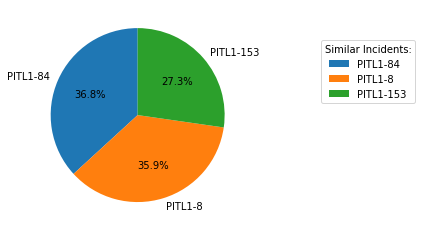

In [53]:
import json
import matplotlib.pyplot as plt

# Convert result to JSON
response=json.dumps(result)
print("Response", response)

data = json.loads(response)

incidents=[]
scores=[]
for values in data:
  incidents.append(values["issue_key"])
  scores.append(values["similarity_score"])

# Similar incidents 
plt.pie(scores,labels=incidents,autopct='%1.1f%%',startangle = 90)
plt.legend(title = "Similar Incidents:", loc='right', bbox_to_anchor=(1,0.2,0.8,1))
plt.show()




In [54]:
#Predicting aggregated response for all Jira incidents

aggregate_result=[]
for i in range(len(documents)):
  desc_cos_scores = util.pytorch_cos_sim(text_embeddings[i], text_embeddings)[0]
  # Compute similarity scores of the incidents with respect to summary 
  cos_scores_summary = util.pytorch_cos_sim(summary_text_embeddings[i], summary_text_embeddings)[0]

  #Merge both the description scores and summary scores
  cos_scores=(0.65)*desc_cos_scores+(0.35)*cos_scores_summary
  top_k=4

  top_results = np.argpartition(-cos_scores, range(top_k))[0:top_k+1]
  result=[]
  for idx in top_results[0:top_k]:
      result.append({
      "issue_id":str(df['Issue id'][int(idx)]),
      "issue_key":str(df['Issue key'][int(idx)]),
      "assignee":str(df['Assignee'][int(idx)]),
      "similarity_score":"%.4f"%float(cos_scores[idx]),  
      "reporter":str(df['Reporter'][int(idx)]),
      "summary":str(df['Summary'][int(idx)]),
      "description":str(df['Description'][int(idx)])
      })
  aggregate_result.append(result)

# Exporting the predicted results of all Jira incidents
response=json.dumps(aggregate_result)
with open("response.json", "w") as outfile:
    outfile.write(response)